# 📈 Stock Price Prediction System

**End-to-End ML Pipeline** — From data collection to production-ready predictions.

**Models Used:** Linear Regression · Decision Tree · Random Forest · Logistic Regression (Direction)

**Author:** Final Year Student — ML Engineering & Quant Development

---

## 1. Setup & Imports
Install necessary libraries and configure the environment.

In [2]:
# Install dependencies (uncomment if needed)
# !pip install yfinance pandas numpy scikit-learn matplotlib seaborn shap ta statsmodels joblib

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import joblib
import os
from datetime import datetime, timedelta

# Sklearn
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                             accuracy_score, classification_report)
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

# Stationarity
from statsmodels.tsa.stattools import adfuller

# Set seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Plot style
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12
sns.set_palette('viridis')

# Directories
os.makedirs('../data', exist_ok=True)
os.makedirs('../models', exist_ok=True)

print("✅ All imports successful!")
print(f"   NumPy: {np.__version__}")
print(f"   Pandas: {pd.__version__}")
print(f"   Scikit-learn: {__import__('sklearn').__version__}")

✅ All imports successful!
   NumPy: 2.4.2
   Pandas: 2.3.3
   Scikit-learn: 1.8.0


---
## 2. Data Collection

**Objective:** Fetch historical stock data dynamically using `yfinance`.

Features:
- Dynamic ticker selection
- Local CSV caching
- Error handling with retry logic

In [3]:
# ── Configuration ──
TICKER = 'AAPL'       # Change this to any ticker: GOOGL, MSFT, TSLA, etc.
PERIOD = '25y'          # Data period: 1y, 2y, 5y, max
CACHE_FILE = f'../data/{TICKER}_{PERIOD}.csv'

def fetch_stock_data(ticker, period='5y', use_cache=True):
    """Fetch historical OHLCV data with caching and error handling."""
    cache_path = f'../data/{ticker}_{period}.csv'

    # Try cache first
    if use_cache and os.path.exists(cache_path):
        print(f"📂 Loading cached data from {cache_path}")
        df = pd.read_csv(cache_path, index_col='Date', parse_dates=True)
        return df

    # Download from yfinance with retry
    for attempt in range(3):
        try:
            print(f"📥 Downloading {ticker} data (attempt {attempt+1}/3)...")
            stock = yf.Ticker(ticker)
            df = stock.history(period=period, auto_adjust=False)

            if df.empty:
                raise ValueError(f"No data returned for '{ticker}'")

            df.index.name = 'Date'
            keep = ['Open','High','Low','Close','Volume']
            if 'Adj Close' in df.columns:
                keep.append('Adj Close')
            df = df[[c for c in keep if c in df.columns]]

            df.to_csv(cache_path)
            print(f"✅ Downloaded {len(df)} rows. Cached to {cache_path}")
            return df
        except Exception as e:
            print(f"⚠️ Attempt {attempt+1} failed: {e}")
            if attempt == 2:
                raise

# Fetch data
df = fetch_stock_data(TICKER, PERIOD)
print(f"\n📊 Dataset shape: {df.shape}")
print(f"📅 Date range: {df.index[0].date()} to {df.index[-1].date()}")
df.head(10)

📥 Downloading AAPL data (attempt 1/3)...
✅ Downloaded 6286 rows. Cached to ../data/AAPL_25y.csv

📊 Dataset shape: (6286, 6)
📅 Date range: 2001-02-20 to 2026-02-18


,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2001-02-20 00:00:00-05:00,0.342634,0.347098,0.324777,0.327009,314893600,0.274349
2001-02-21 00:00:00-05:00,0.325893,0.356027,0.325893,0.337054,390258400,0.282776
2001-02-22 00:00:00-05:00,0.340402,0.345982,0.321429,0.335938,431961600,0.281840
2001-02-23 00:00:00-05:00,0.332589,0.337054,0.325893,0.335938,293865600,0.281840
2001-02-26 00:00:00-05:00,0.340402,0.351563,0.331473,0.348214,206438400,0.292139
2001-02-27 00:00:00-05:00,0.344308,0.347098,0.333705,0.345982,348516000,0.290266
2001-02-28 00:00:00-05:00,0.345982,0.347098,0.323661,0.325893,508233600,0.273413
2001-03-01 00:00:00-05:00,0.318080,0.334821,0.306920,0.334821,330461600,0.280903
2001-03-02 00:00:00-05:00,0.327009,0.364955,0.325893,0.343750,406201600,0.288394


---
## 3. Exploratory Data Analysis (EDA)

### 3.1 Data Overview & Missing Values

In [4]:
# Basic info
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"\nShape: {df.shape}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")
print(f"\nStatistical Summary:\n")
df.describe().round(2)

DATASET OVERVIEW

Shape: (6286, 6)

Data Types:
Open         float64
High         float64
Low          float64
Close        float64
Volume         int64
Adj Close    float64
dtype: object

Missing Values:
Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64

Statistical Summary:



,Open,High,Low,Close,Volume,Adj Close
count,6286.00,6286.00,6286.00,6286.00,6.286000e+03,6286.00
mean,53.25,53.82,52.70,53.28,3.664949e+08,51.60
std,71.84,72.61,71.13,71.90,3.740630e+08,71.59
min,0.23,0.24,0.23,0.23,1.791060e+07,0.20
25%,3.27,3.33,3.20,3.26,1.020372e+08,2.74
50%,20.16,20.33,19.95,20.15,2.375900e+08,17.12
75%,61.87,63.95,60.99,62.03,4.955370e+08,59.84
max,286.20,288.62,283.30,286.19,3.372970e+09,285.92


### 3.2 Price Trend & Volume

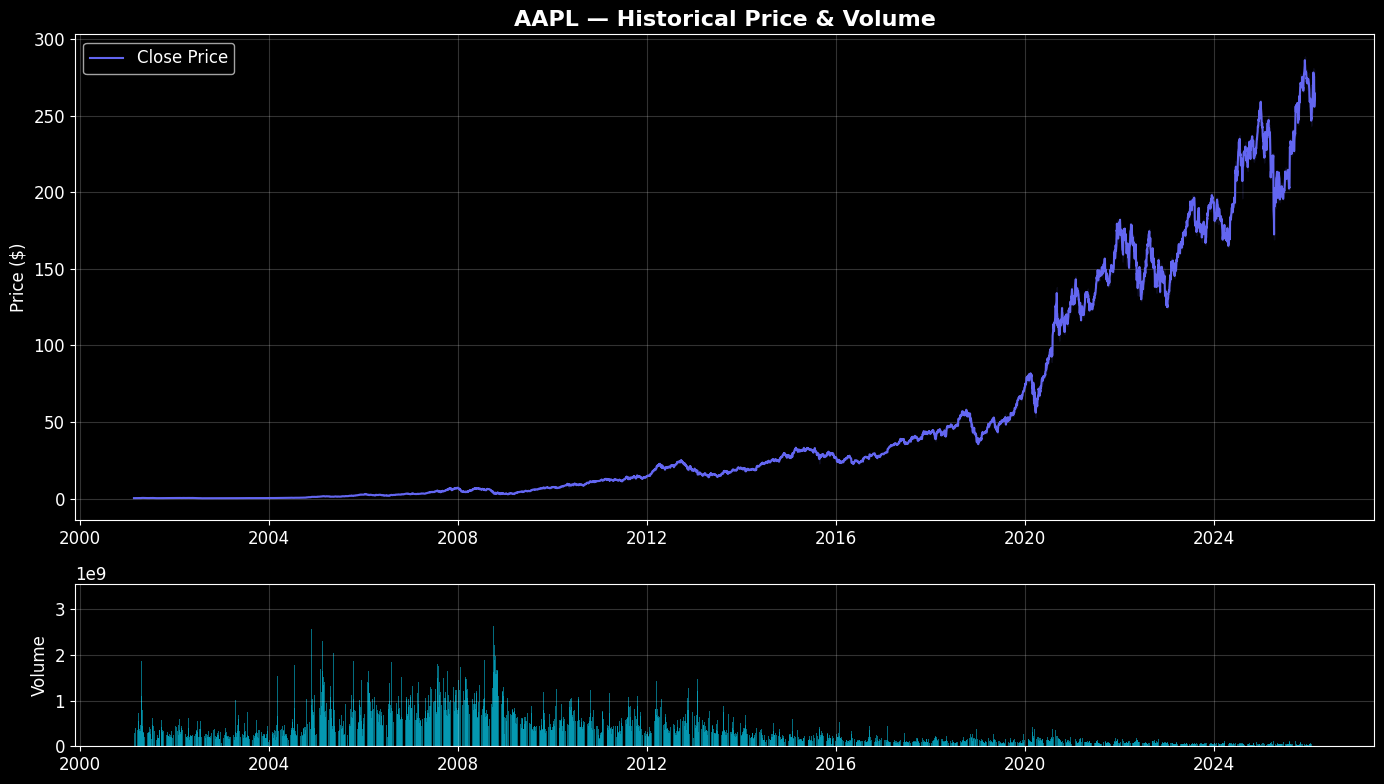

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8), gridspec_kw={'height_ratios': [3, 1]})

# Price
axes[0].plot(df.index, df['Close'], color='#6366f1', linewidth=1.5, label='Close Price')
axes[0].fill_between(df.index, df['Low'], df['High'], alpha=0.1, color='#6366f1')
axes[0].set_title(f'{TICKER} — Historical Price & Volume', fontsize=16, fontweight='bold')
axes[0].set_ylabel('Price ($)')
axes[0].legend()
axes[0].grid(alpha=0.2)

# Volume
axes[1].bar(df.index, df['Volume'], color='#06b6d4', alpha=0.6, width=2)
axes[1].set_ylabel('Volume')
axes[1].grid(alpha=0.2)

plt.tight_layout()
plt.show()

### 3.3 Moving Averages Visualization

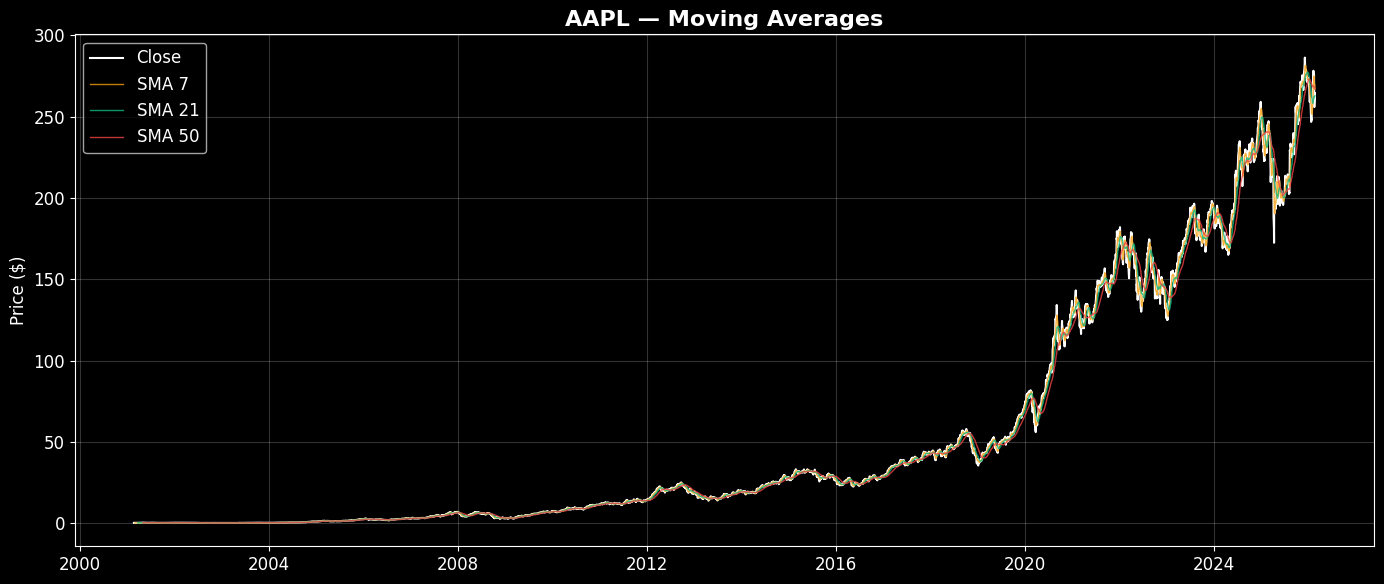

In [6]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(df.index, df['Close'], label='Close', color='white', linewidth=1.5)
for window, color in [(7,'#f59e0b'), (21,'#10b981'), (50,'#ef4444')]:
    sma = df['Close'].rolling(window).mean()
    ax.plot(df.index, sma, label=f'SMA {window}', color=color, linewidth=1, alpha=0.8)

ax.set_title(f'{TICKER} — Moving Averages', fontsize=16, fontweight='bold')
ax.set_ylabel('Price ($)')
ax.legend()
ax.grid(alpha=0.2)
plt.tight_layout()
plt.show()

### 3.4 Return Distribution

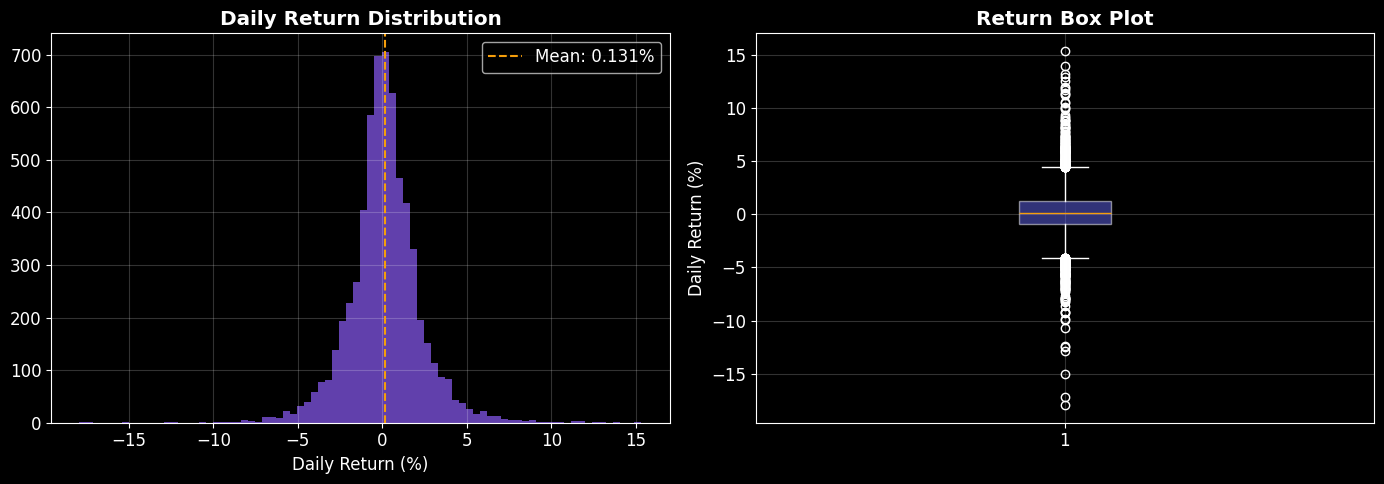

Mean return:  0.1306%
Std dev:      2.1938%
Skewness:     0.0770
Kurtosis:     5.5642


In [7]:
daily_returns = df['Close'].pct_change().dropna() * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(daily_returns, bins=80, color='#8b5cf6', alpha=0.7, edgecolor='none')
axes[0].axvline(daily_returns.mean(), color='#f59e0b', linestyle='--', label=f'Mean: {daily_returns.mean():.3f}%')
axes[0].set_title('Daily Return Distribution', fontweight='bold')
axes[0].set_xlabel('Daily Return (%)')
axes[0].legend()
axes[0].grid(alpha=0.2)

# Box plot
axes[1].boxplot(daily_returns, vert=True, patch_artist=True,
                boxprops=dict(facecolor='#6366f1', alpha=0.5),
                medianprops=dict(color='#f59e0b'))
axes[1].set_title('Return Box Plot', fontweight='bold')
axes[1].set_ylabel('Daily Return (%)')
axes[1].grid(alpha=0.2)

plt.tight_layout()
plt.show()

print(f"Mean return:  {daily_returns.mean():.4f}%")
print(f"Std dev:      {daily_returns.std():.4f}%")
print(f"Skewness:     {daily_returns.skew():.4f}")
print(f"Kurtosis:     {daily_returns.kurtosis():.4f}")

---
## 4. Feature Engineering

Create technical indicators used by professional traders and quant researchers.

In [8]:
def add_technical_indicators(df):
    """Add all technical indicators to the DataFrame."""
    data = df.copy()

    # Simple Moving Averages
    for w in [7, 21, 50]:
        data[f'SMA_{w}'] = data['Close'].rolling(w).mean()

    # Exponential Moving Averages
    for w in [12, 26]:
        data[f'EMA_{w}'] = data['Close'].ewm(span=w, adjust=False).mean()

    # RSI (Relative Strength Index)
    delta = data['Close'].diff()
    gain = delta.clip(lower=0).rolling(14).mean()
    loss = (-delta.clip(upper=0)).rolling(14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))

    # MACD
    ema12 = data['Close'].ewm(span=12, adjust=False).mean()
    ema26 = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = ema12 - ema26
    data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
    data['MACD_Hist'] = data['MACD'] - data['MACD_Signal']

    # Bollinger Bands
    sma20 = data['Close'].rolling(20).mean()
    std20 = data['Close'].rolling(20).std()
    data['BB_Upper'] = sma20 + 2 * std20
    data['BB_Middle'] = sma20
    data['BB_Lower'] = sma20 - 2 * std20
    data['BB_Width'] = (data['BB_Upper'] - data['BB_Lower']) / data['BB_Middle']

    # Daily Returns
    data['Daily_Return'] = data['Close'].pct_change() * 100

    # Lag Features
    for lag in range(1, 6):
        data[f'Close_Lag_{lag}'] = data['Close'].shift(lag)

    # Volume features
    data['Volume_SMA_20'] = data['Volume'].rolling(20).mean()
    data['Volume_Ratio'] = data['Volume'] / data['Volume_SMA_20']

    return data

# Apply feature engineering
df_featured = add_technical_indicators(df)
print(f"Columns after feature engineering: {len(df_featured.columns)}")
print(f"\nNew features: {[c for c in df_featured.columns if c not in df.columns]}")
df_featured.tail()

Columns after feature engineering: 27

New features: ['SMA_7', 'SMA_21', 'SMA_50', 'EMA_12', 'EMA_26', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist', 'BB_Upper', 'BB_Middle', 'BB_Lower', 'BB_Width', 'Daily_Return', 'Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3', 'Close_Lag_4', 'Close_Lag_5', 'Volume_SMA_20', 'Volume_Ratio']


,Open,High,Low,Close,Volume,Adj Close,SMA_7,SMA_21,SMA_50,EMA_12,...,BB_Lower,BB_Width,Daily_Return,Close_Lag_1,Close_Lag_2,Close_Lag_3,Close_Lag_4,Close_Lag_5,Volume_SMA_20,Volume_Ratio
Date,,,,,,,,,,,,,,,,,,,,,
2026-02-11 00:00:00-05:00,274.700012,280.179993,274.450012,275.500000,51931300,275.500000,274.828570,262.246665,268.510798,269.947307,...,240.544544,0.165928,0.665013,273.679993,274.619995,278.119995,275.910004,276.489990,56883770.0,0.912937
2026-02-12 00:00:00-05:00,275.589996,275.720001,260.179993,261.730011,81077200,261.730011,273.721427,262.279047,268.083398,268.683108,...,240.658843,0.165675,-4.998181,275.500000,273.679993,274.619995,278.119995,275.910004,58936660.0,1.375667
2026-02-13 00:00:00-05:00,262.010010,262.230011,255.449997,255.779999,56290700,255.779999,270.762857,262.080000,267.475198,266.698014,...,240.412041,0.166707,-2.273340,261.730011,275.500000,273.679993,274.619995,278.119995,59781765.0,0.941603
2026-02-17 00:00:00-05:00,258.049988,266.290009,255.539993,263.880005,58469100,263.880005,269.044285,262.350000,267.069799,266.264474,...,241.054015,0.164733,3.166786,255.779999,261.730011,275.500000,273.679993,274.619995,59098080.0,0.989357
2026-02-18 00:00:00-05:00,263.600006,266.820007,262.450012,264.350006,34129600,264.350006,267.077144,262.770001,266.742798,265.969941,...,243.284951,0.153950,0.178112,263.880005,255.779999,261.730011,275.500000,273.679993,56791185.0,0.600967


### 4.1 Stationarity Check (ADF Test)

In [9]:
# Augmented Dickey-Fuller Test for stationarity
result = adfuller(df['Close'].dropna())
print("ADF Statistic (Close Price):", round(result[0], 4))
print("p-value:", round(result[1], 4))
print("Stationary?" , "Yes ✅" if result[1] < 0.05 else "No ❌ (expected for stock prices)")

# Test returns (should be stationary)
returns = df['Close'].pct_change().dropna()
result2 = adfuller(returns)
print(f"\nADF Statistic (Returns): {round(result2[0], 4)}")
print(f"p-value: {round(result2[1], 6)}")
print("Stationary?", "Yes ✅" if result2[1] < 0.05 else "No ❌")

ADF Statistic (Close Price): 1.9305
p-value: 0.9986
Stationary? No ❌ (expected for stock prices)

ADF Statistic (Returns): -25.9952
p-value: 0.0
Stationary? Yes ✅


### 4.2 Feature Correlation Heatmap

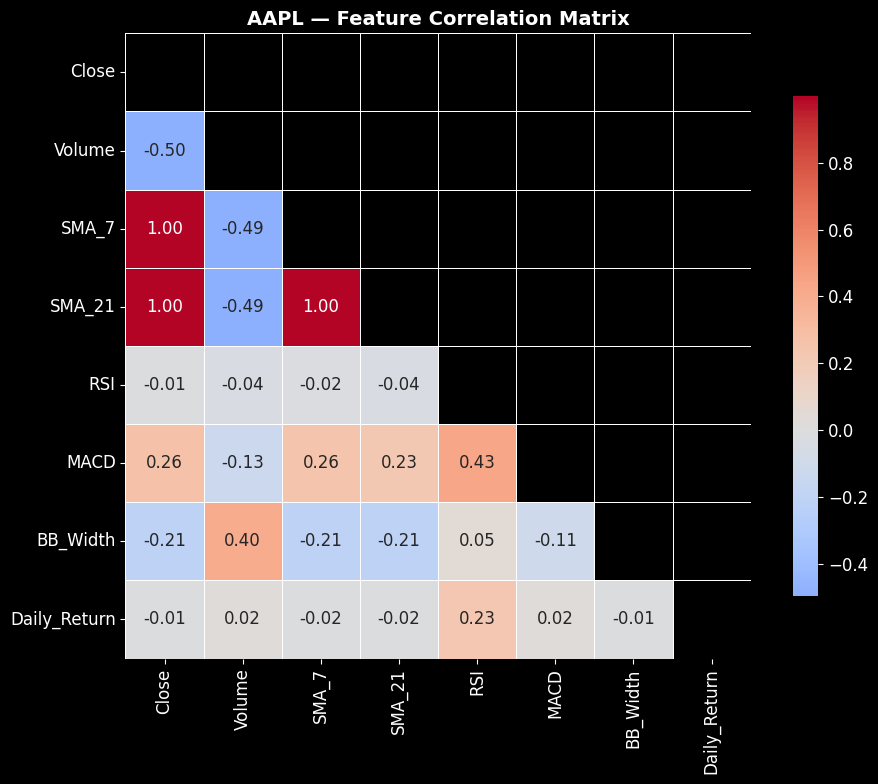

In [10]:
# Select key features for correlation
key_features = ['Close', 'Volume', 'SMA_7', 'SMA_21', 'RSI', 'MACD', 'BB_Width', 'Daily_Return']
corr_data = df_featured[key_features].dropna()

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_data.corr(), dtype=bool))
sns.heatmap(corr_data.corr(), mask=mask, annot=True, fmt='.2f',
            cmap='coolwarm', center=0, ax=ax, linewidths=0.5,
            square=True, cbar_kws={'shrink': 0.8})
ax.set_title(f'{TICKER} — Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 5. Data Preparation & Train/Test Split

Using **time-based split** (80/20) to prevent data leakage.

In [11]:
# Prepare features
df_clean = df_featured.dropna()
exclude_cols = ['Close', 'Adj Close']
feature_cols = [c for c in df_clean.columns if c not in exclude_cols]

X = df_clean[feature_cols]
y = df_clean['Close']

# Time-based split (NO shuffling!)
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Training set:  {X_train.shape[0]} samples ({X_train.index[0].date()} to {X_train.index[-1].date()})")
print(f"Testing set:   {X_test.shape[0]} samples ({X_test.index[0].date()} to {X_test.index[-1].date()})")
print(f"Features:      {X_train.shape[1]}")

# Scale features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f"\n✅ Features scaled using MinMaxScaler")

Training set:  4989 samples (2001-05-01 to 2021-03-01)
Testing set:   1248 samples (2021-03-02 to 2026-02-18)
Features:      25

✅ Features scaled using MinMaxScaler


---
## 6. Baseline Models

### 6.1 Naive Forecast
Predicts tomorrow's price = today's price.

In [12]:
# Naive forecast: predict previous day's price
naive_preds = y_test.shift(1).dropna()
naive_actual = y_test.iloc[1:]

naive_rmse = np.sqrt(mean_squared_error(naive_actual, naive_preds))
naive_mae = mean_absolute_error(naive_actual, naive_preds)
print(f"Naive Forecast — RMSE: {naive_rmse:.4f} | MAE: {naive_mae:.4f}")

Naive Forecast — RMSE: 3.1670 | MAE: 2.2306


### 6.2 Linear Regression

In [13]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_preds = lr_model.predict(X_test_scaled)

lr_rmse = np.sqrt(mean_squared_error(y_test, lr_preds))
lr_mae = mean_absolute_error(y_test, lr_preds)
print(f"Linear Regression — RMSE: {lr_rmse:.4f} | MAE: {lr_mae:.4f}")

Linear Regression — RMSE: 0.6065 | MAE: 0.4641


---
## 7. Machine Learning Models

### 7.1 Decision Tree Regressor

**Why?** Captures non-linear patterns without requiring feature scaling assumptions. Simple, interpretable model.

In [14]:
dt_model = DecisionTreeRegressor(
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=RANDOM_SEED
)
dt_model.fit(X_train_scaled, y_train)
dt_preds = dt_model.predict(X_test_scaled)

dt_rmse = np.sqrt(mean_squared_error(y_test, dt_preds))
dt_mae = mean_absolute_error(y_test, dt_preds)
print(f"Decision Tree — RMSE: {dt_rmse:.4f} | MAE: {dt_mae:.4f}")

Decision Tree — RMSE: 59.7560 | MAE: 45.5937


### 7.2 Random Forest Regressor

**Why?** Ensemble of decision trees — reduces overfitting via bagging. Usually the best performer for tabular data.

In [15]:
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    random_state=RANDOM_SEED,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)
rf_preds = rf_model.predict(X_test_scaled)

rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_mae = mean_absolute_error(y_test, rf_preds)
print(f"Random Forest — RMSE: {rf_rmse:.4f} | MAE: {rf_mae:.4f}")

Random Forest — RMSE: 59.4262 | MAE: 45.2078


### 7.3 Logistic Regression (Direction Prediction)

**Why?** Classification model to predict if price will go **up or down** the next day. Gives directional accuracy.

In [16]:
# Create binary direction labels: 1 = up, 0 = down
y_train_dir = (y_train.diff().dropna() > 0).astype(int)
y_test_dir = (y_test.diff().dropna() > 0).astype(int)
X_train_dir = X_train_scaled[1:]
X_test_dir = X_test_scaled[1:]

log_model = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED, class_weight='balanced')
log_model.fit(X_train_dir, y_train_dir)
log_preds = log_model.predict(X_test_dir)

dir_accuracy = accuracy_score(y_test_dir, log_preds) * 100
print(f"Logistic Regression (Direction) — Accuracy: {dir_accuracy:.2f}%")
print(f"\nClassification Report:\n{classification_report(y_test_dir, log_preds, target_names=['Down','Up'])}")

Logistic Regression (Direction) — Accuracy: 95.19%

Classification Report:
              precision    recall  f1-score   support

        Down       0.94      0.96      0.95       586
          Up       0.96      0.95      0.95       661

    accuracy                           0.95      1247
   macro avg       0.95      0.95      0.95      1247
weighted avg       0.95      0.95      0.95      1247



---
## 8. Hyperparameter Tuning

Using **TimeSeriesSplit** cross-validation + **RandomizedSearchCV** for Random Forest.

In [17]:
param_distributions = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5, 0.8],
}

tscv = TimeSeriesSplit(n_splits=5)

search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1),
    param_distributions=param_distributions,
    n_iter=20,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_SEED,
    n_jobs=-1,
    verbose=1,
)

print("🔧 Running hyperparameter tuning (this may take 1-2 minutes)...")
search.fit(X_train_scaled, y_train)

print(f"\n✅ Best Parameters: {search.best_params_}")
print(f"   Best CV RMSE: {-search.best_score_:.4f}")

# Evaluate tuned model
rf_tuned = search.best_estimator_
rf_tuned_preds = rf_tuned.predict(X_test_scaled)
rf_tuned_rmse = np.sqrt(mean_squared_error(y_test, rf_tuned_preds))
rf_tuned_mae = mean_absolute_error(y_test, rf_tuned_preds)
print(f"\nTuned Random Forest — RMSE: {rf_tuned_rmse:.4f} | MAE: {rf_tuned_mae:.4f}")

🔧 Running hyperparameter tuning (this may take 1-2 minutes)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

✅ Best Parameters: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.8, 'max_depth': 10}
   Best CV RMSE: 11.0971

Tuned Random Forest — RMSE: 59.4079 | MAE: 45.1845


---
## 9. Model Evaluation

### 9.1 Performance Comparison

In [18]:
def compute_all_metrics(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    actual_dir = np.sign(np.diff(y_true))
    pred_dir = np.sign(np.diff(y_pred))
    dir_acc = np.mean(actual_dir == pred_dir) * 100
    return {'Model': name, 'RMSE': rmse, 'MAE': mae, 'MAPE (%)': mape, 'Dir Acc (%)': dir_acc}

all_models = {
    'Linear Regression': lr_preds,
    'Decision Tree': dt_preds,
    'Random Forest': rf_preds,
    'RF Tuned': rf_tuned_preds,
}

comparison = pd.DataFrame([
    compute_all_metrics(y_test.values, preds, name)
    for name, preds in all_models.items()
])
comparison = comparison.sort_values('RMSE')
print("\n📊 Model Comparison (sorted by RMSE):\n")
comparison.round(4)


📊 Model Comparison (sorted by RMSE):



,Model,RMSE,MAE,MAPE (%),Dir Acc (%)
0,Linear Regression,0.6065,0.4641,0.2564,94.0658
3,RF Tuned,59.4079,45.1845,21.1816,70.0882
2,Random Forest,59.4262,45.2078,21.1946,53.0874
1,Decision Tree,59.7560,45.5937,21.4052,5.4531


### 9.2 Actual vs Predicted Plots

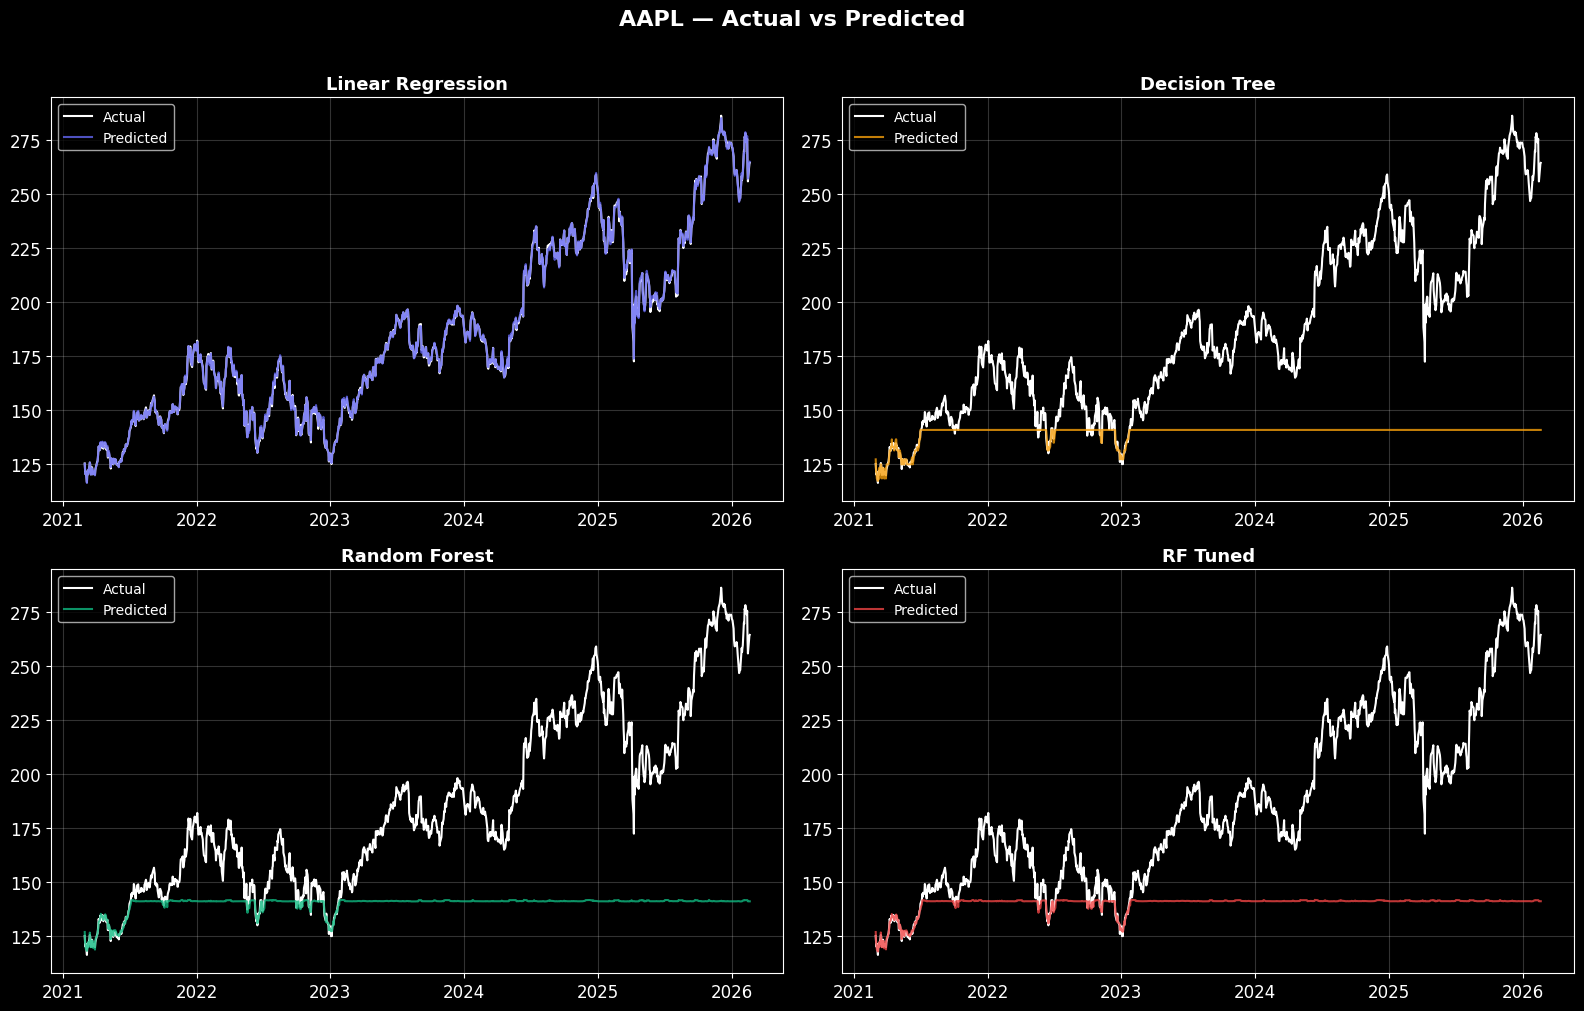

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
colors = ['#6366f1', '#f59e0b', '#10b981', '#ef4444']

for idx, (name, preds) in enumerate(all_models.items()):
    ax = axes[idx // 2][idx % 2]
    ax.plot(y_test.index, y_test.values, label='Actual', color='white', linewidth=1.5)
    ax.plot(y_test.index, preds, label=f'Predicted', color=colors[idx], linewidth=1.5, alpha=0.8)
    ax.set_title(name, fontweight='bold', fontsize=13)
    ax.legend(fontsize=10)
    ax.grid(alpha=0.2)

plt.suptitle(f'{TICKER} — Actual vs Predicted', fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

### 9.3 Residual Analysis

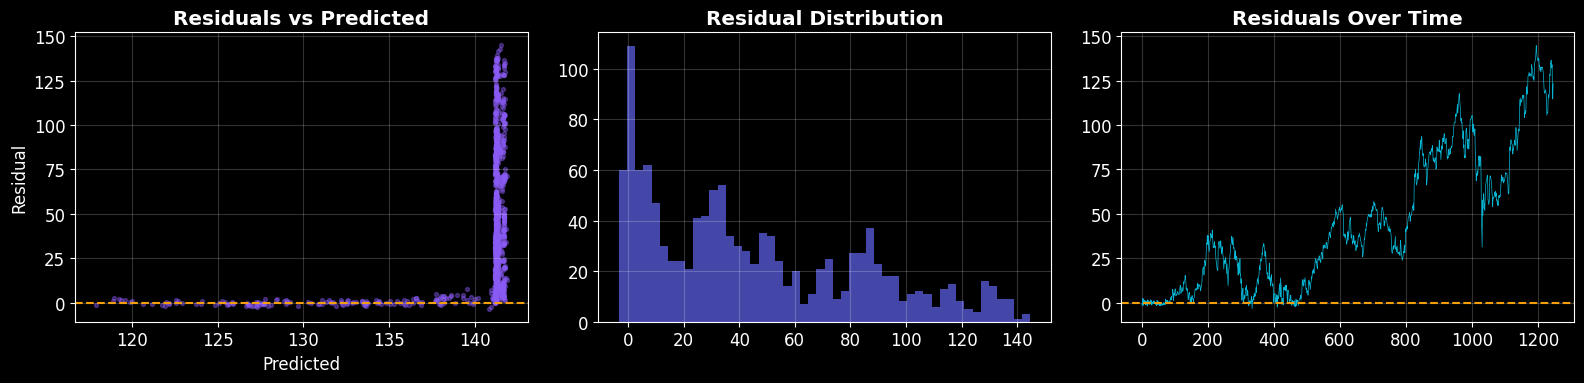

Mean residual:   45.0682
Std of residuals: 38.7061


In [20]:
# Use best model (tuned RF)
best_preds = rf_tuned_preds
residuals = y_test.values - best_preds

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

axes[0].scatter(best_preds, residuals, alpha=0.4, s=8, color='#8b5cf6')
axes[0].axhline(y=0, color='#f59e0b', linestyle='--')
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('Residual')
axes[0].set_title('Residuals vs Predicted', fontweight='bold')
axes[0].grid(alpha=0.2)

axes[1].hist(residuals, bins=50, color='#6366f1', alpha=0.7, edgecolor='none')
axes[1].set_title('Residual Distribution', fontweight='bold')
axes[1].grid(alpha=0.2)

axes[2].plot(residuals, color='#06b6d4', linewidth=0.5)
axes[2].axhline(y=0, color='#f59e0b', linestyle='--')
axes[2].set_title('Residuals Over Time', fontweight='bold')
axes[2].grid(alpha=0.2)

plt.tight_layout()
plt.show()

print(f"Mean residual:   {residuals.mean():.4f}")
print(f"Std of residuals: {residuals.std():.4f}")

---
## 10. Model Interpretation

### 10.1 Feature Importance (Random Forest)

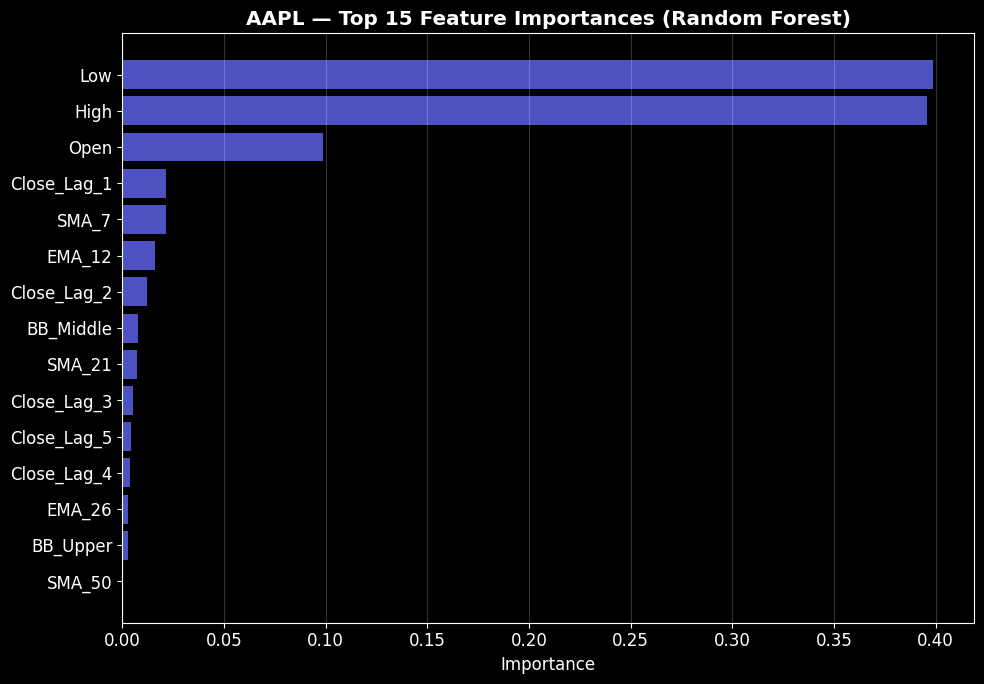

In [21]:
importances = rf_tuned.feature_importances_
feat_imp = pd.DataFrame({'Feature': feature_cols, 'Importance': importances})
feat_imp = feat_imp.sort_values('Importance', ascending=True).tail(15)

fig, ax = plt.subplots(figsize=(10, 7))
ax.barh(feat_imp['Feature'], feat_imp['Importance'], color='#6366f1', alpha=0.8)
ax.set_xlabel('Importance')
ax.set_title(f'{TICKER} — Top 15 Feature Importances (Random Forest)', fontweight='bold')
ax.grid(alpha=0.2, axis='x')
plt.tight_layout()
plt.show()

### 10.2 SHAP Analysis

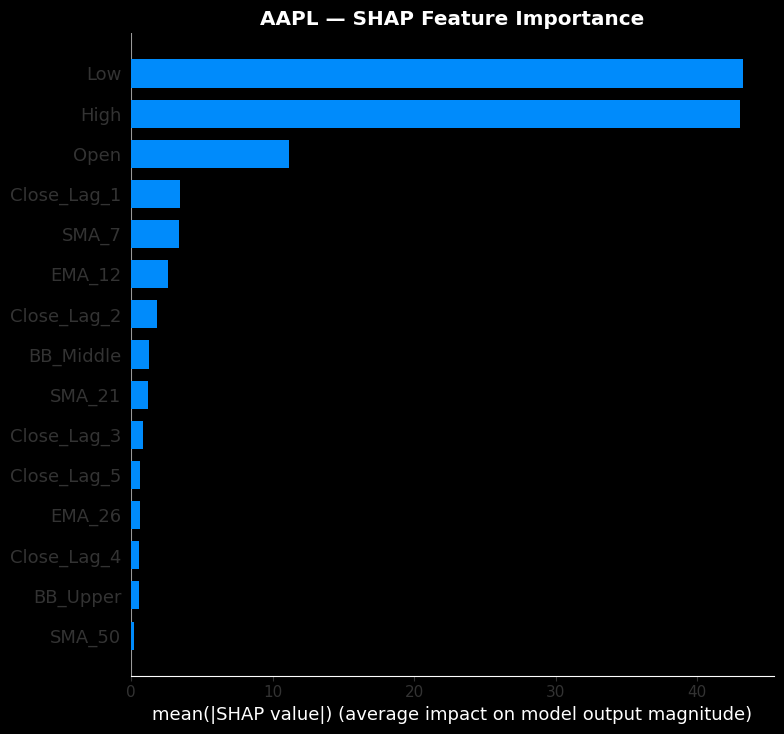

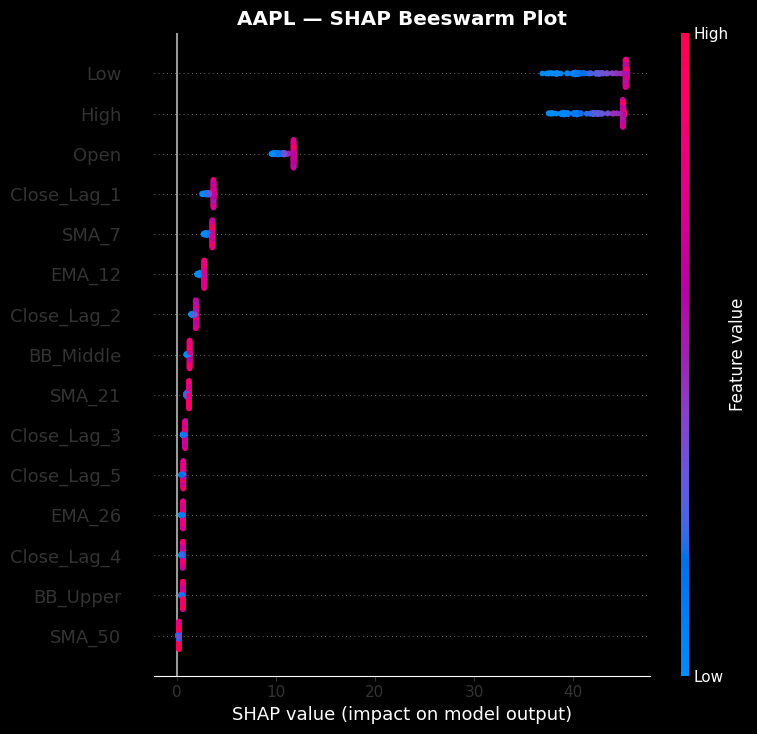


🔍 Key insights from SHAP:
   • Lag features and moving averages are typically most influential
   • RSI and MACD provide non-linear signal the model leverages


In [22]:
try:
    import shap

    explainer = shap.TreeExplainer(rf_tuned)
    # Use a sample for speed
    sample_size = min(200, len(X_test_scaled))
    X_sample = X_test_scaled[:sample_size]

    shap_values = explainer.shap_values(X_sample)

    fig, ax = plt.subplots(figsize=(10, 8))
    shap.summary_plot(shap_values, X_sample, feature_names=feature_cols,
                      plot_type='bar', show=False, max_display=15)
    plt.title(f'{TICKER} — SHAP Feature Importance', fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Beeswarm plot
    shap.summary_plot(shap_values, X_sample, feature_names=feature_cols,
                      show=False, max_display=15)
    plt.title(f'{TICKER} — SHAP Beeswarm Plot', fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("\n🔍 Key insights from SHAP:")
    print("   • Lag features and moving averages are typically most influential")
    print("   • RSI and MACD provide non-linear signal the model leverages")
except ImportError:
    print("⚠️ SHAP not installed. Run: pip install shap")

---
## 11. Production Pipeline

Save the best model and create a reusable prediction function.

In [23]:
# Save model artifacts
joblib.dump(rf_tuned, f'../models/{TICKER}_model.pkl')
joblib.dump(scaler, f'../models/{TICKER}_scaler.pkl')
joblib.dump({
    'ticker': TICKER,
    'best_model': 'RandomForest_Tuned',
    'feature_names': feature_cols,
    'metrics': compute_all_metrics(y_test.values, rf_tuned_preds, 'RF_Tuned'),
}, f'../models/{TICKER}_meta.pkl')

print(f"✅ Model saved to ../models/{TICKER}_model.pkl")
print(f"✅ Scaler saved to ../models/{TICKER}_scaler.pkl")

✅ Model saved to ../models/AAPL_model.pkl
✅ Scaler saved to ../models/AAPL_scaler.pkl


In [24]:
def predict_stock(ticker, days_ahead=5):
    """
    Predict future stock prices for the next N trading days.

    Parameters
    ----------
    ticker : str — Stock ticker symbol
    days_ahead : int — Number of trading days to predict

    Returns
    -------
    dict with predictions, history, and model info
    """
    # Load artifacts
    model = joblib.load(f'../models/{ticker}_model.pkl')
    scaler = joblib.load(f'../models/{ticker}_scaler.pkl')
    meta = joblib.load(f'../models/{ticker}_meta.pkl')

    # Fetch latest data
    stock = yf.Ticker(ticker)
    df = stock.history(period='2y', auto_adjust=False)
    df.index.name = 'Date'
    keep = ['Open','High','Low','Close','Volume']
    if 'Adj Close' in df.columns: keep.append('Adj Close')
    df = df[[c for c in keep if c in df.columns]]

    working_df = df.copy()
    last_date = working_df.index[-1]
    predictions = []

    for day in range(1, days_ahead + 1):
        enriched = add_technical_indicators(working_df).dropna()
        feat_cols = meta['feature_names']
        last_row = enriched[feat_cols].iloc[[-1]]
        last_scaled = scaler.transform(last_row)
        pred_price = float(model.predict(last_scaled)[0])

        next_date = last_date + timedelta(days=1)
        while next_date.weekday() >= 5:
            next_date += timedelta(days=1)

        predictions.append({'date': next_date.strftime('%Y-%m-%d'), 'close': round(pred_price, 2)})

        new_row = pd.DataFrame({
            'Open': [pred_price], 'High': [pred_price*1.005],
            'Low': [pred_price*0.995], 'Close': [pred_price],
            'Volume': [working_df['Volume'].tail(5).mean()],
        }, index=[next_date])
        if 'Adj Close' in working_df.columns: new_row['Adj Close'] = pred_price
        working_df = pd.concat([working_df, new_row])
        last_date = next_date

    return {
        'ticker': ticker, 'model': meta['best_model'],
        'predictions': predictions, 'metrics': meta['metrics']
    }

# Test the prediction function
result = predict_stock(TICKER, days_ahead=7)
print(f"\n📈 {TICKER} — {result['model']} Predictions:")
print("-" * 35)
for p in result['predictions']:
    print(f"   {p['date']}: ${p['close']:.2f}")


📈 AAPL — RandomForest_Tuned Predictions:
-----------------------------------
   2026-02-19: $141.19
   2026-02-20: $138.56
   2026-02-23: $136.81
   2026-02-24: $136.40
   2026-02-25: $136.06
   2026-02-26: $135.63
   2026-02-27: $135.23


### 11.1 Forecast Visualization

ConversionError: Failed to convert value(s) to axis units: array([Timestamp('2026-02-18 00:00:00-0500', tz='America/New_York'),
       Timestamp('2026-02-19 00:00:00'), Timestamp('2026-02-20 00:00:00'),
       Timestamp('2026-02-23 00:00:00'), Timestamp('2026-02-24 00:00:00'),
       Timestamp('2026-02-25 00:00:00'), Timestamp('2026-02-26 00:00:00'),
       Timestamp('2026-02-27 00:00:00')], dtype=object)

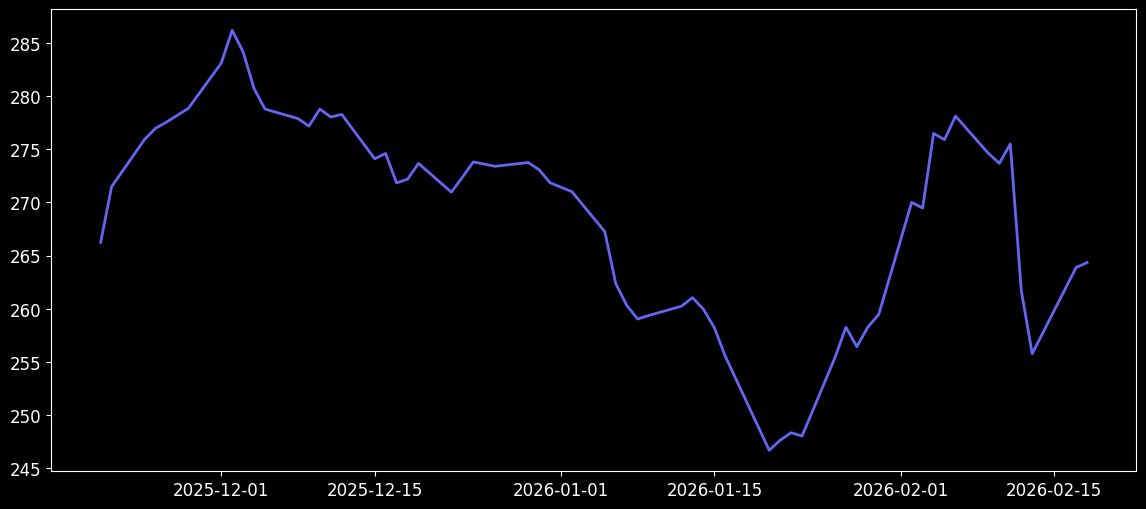

In [25]:
fig, ax = plt.subplots(figsize=(14, 6))

# Plot last 60 days of actual data
recent = df.tail(60)
ax.plot(recent.index, recent['Close'], color='#6366f1', linewidth=2, label='Historical')

# Plot forecast
pred_dates = pd.to_datetime([p['date'] for p in result['predictions']])
pred_values = [p['close'] for p in result['predictions']]

# Connect the lines
bridge_dates = [recent.index[-1]] + list(pred_dates)
bridge_values = [recent['Close'].iloc[-1]] + pred_values

ax.plot(bridge_dates, bridge_values, color='#06b6d4', linewidth=2,
        linestyle='--', marker='o', markersize=6, label='Forecast')
ax.axvline(x=recent.index[-1], color='rgba(255,255,255,0.3)', linestyle=':', label='Forecast Start')

ax.set_title(f'{TICKER} — Price Forecast ({len(pred_values)} days)', fontsize=16, fontweight='bold')
ax.set_ylabel('Price ($)')
ax.legend()
ax.grid(alpha=0.2)
plt.tight_layout()
plt.show()

---
## 12. Deployment Design & Discussion

### Architecture
```
React (Vite) → Express.js → FastAPI → sklearn Model
     ↕              ↕
  Browser        MongoDB
```

### API Endpoint
```
POST /predict
{
  "ticker": "AAPL",
  "days": 5
}
```

### Key Considerations

| Aspect | Approach |
|--------|----------|
| **Inference** | Real-time via FastAPI (< 2s per request) |
| **Model Storage** | joblib serialization to disk |
| **Data Freshness** | 6-hour cache with yfinance |
| **Monitoring** | Log predictions + compare to actuals weekly |
| **Retraining** | Monthly on latest data with full pipeline |
| **Drift Detection** | Track RMSE on recent predictions vs actuals |

### Limitations
- Stock markets are inherently unpredictable — no model guarantees accuracy
- External events (earnings, geopolitics) are not captured
- Short forecast horizons (1-7 days) are more reliable than long-term
- Past performance doesn't guarantee future results

### Potential Enhancements
- News sentiment integration (NLP)
- Multi-company training with shared features
- Market index features (S&P 500, VIX)
- Streamlit dashboard for quick visualization
- Docker deployment for reproducibility

---

**⚠️ Disclaimer:** This project is for educational purposes only. Not financial advice.

---
## ✅ Project Complete!

This notebook demonstrates a full ML pipeline for stock price prediction, including:
1. ✅ Data collection with caching
2. ✅ Comprehensive EDA
3. ✅ Feature engineering (7 technical indicators + lags)
4. ✅ Model comparison (4 models)
5. ✅ Hyperparameter tuning (TimeSeriesSplit + RandomizedSearch)
6. ✅ Evaluation metrics (RMSE, MAE, MAPE, Directional Accuracy)
7. ✅ SHAP interpretation
8. ✅ Production-ready `predict_stock()` function
9. ✅ Deployment design discussion